In [7]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from fbprophet import Prophet
from sklearn.metrics import mean_squared_error, mean_absolute_error
#plt.style.use('fivethirtyeight') # For plots
from sklearn.metrics import mean_squared_error

#statsmodels
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.stattools import acf, pacf
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.statespace.sarimax import SARIMAX

#To ignore warnings
import warnings
warnings.filterwarnings('ignore')

In [8]:
ts = pd.read_csv('../data/PJMW_hourly.csv', index_col=[0], parse_dates=[0])

In [9]:
ts.head()

PJMW_MW
Datetime                    
2002-12-31 01:00:00   5077.0
2002-12-31 02:00:00   4939.0
2002-12-31 03:00:00   4885.0
2002-12-31 04:00:00   4857.0
2002-12-31 05:00:00   4930.0

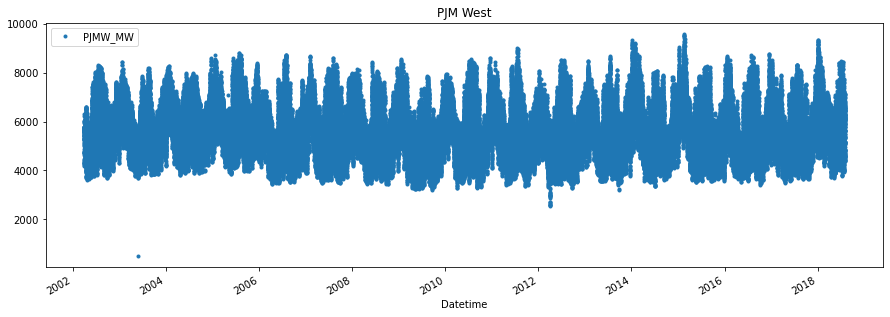

In [10]:
ts.plot(style='.', figsize=(15,5), title='PJM West')
plt.show()

In [11]:
# find the index which allows us to split off 20% of the data
split_date = '01-Jan-2015'
train = ts.loc[ts.index <= split_date].copy()
test = ts.loc[ts.index > split_date].copy()

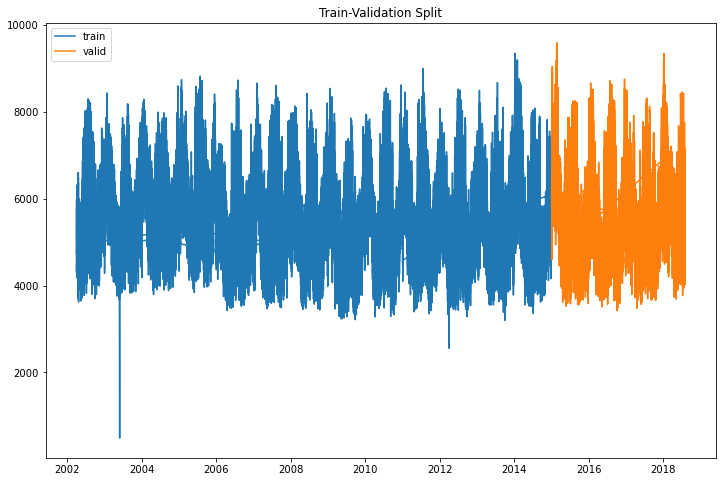

In [12]:
# Define train and test sets according to the index found above

fig, ax = plt.subplots(figsize=(12,8))

ax.plot(train, label='train')
ax.plot(test, label='valid')
ax.set_title('Train-Validation Split');
plt.legend()

## Baseline

In [13]:
naive = train.shift(1)
naive

PJMW_MW
Datetime                    
2002-12-31 01:00:00      NaN
2002-12-31 02:00:00   5077.0
2002-12-31 03:00:00   4939.0
2002-12-31 04:00:00   4885.0
2002-12-31 05:00:00   4857.0
...                      ...
2014-01-01 20:00:00   6377.0
2014-01-01 21:00:00   6371.0
2014-01-01 22:00:00   6378.0
2014-01-01 23:00:00   6204.0
2014-01-02 00:00:00   5897.0

[111767 rows x 1 columns]

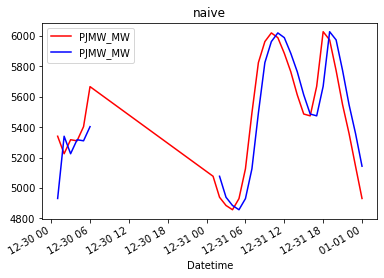

In [14]:
fig, ax = plt.subplots()

train[0:30].plot(ax=ax, c='r', label='original')
naive[0:30].plot(ax=ax, c='b', label='shifted')
ax.set_title('naive')
ax.legend();

In [15]:
np.sqrt(mean_squared_error(train[1:], naive.dropna()))

246.41837117700075

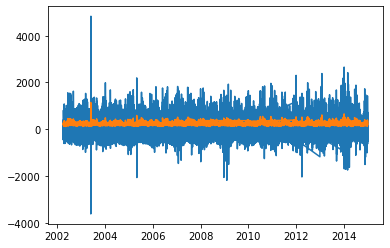

In [16]:
fig, ax = plt.subplots()
residuals = naive[1:] - train[1:]
ax.plot(residuals.index, residuals)
ax.plot(residuals.index, residuals.rolling(30).std());

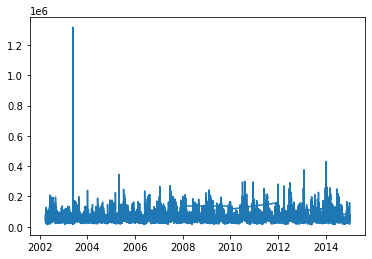

In [17]:
fig, ax = plt.subplots()

ax.plot(residuals.index, residuals.rolling(30).var());

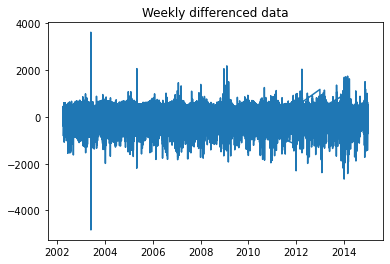

In [18]:
fig, ax = plt.subplots()
ax.plot(train.diff())
ax.set_title('Weekly differenced data');

### Autoregressive Model

In [19]:
ar_1 = ARIMA(train, order=(1, 1, 0)).fit()

# We put a typ='levels' to convert our predictions to remove the differencing performed.
ar_1.predict(typ='levels')

Datetime
2002-12-31 01:00:00       0.000000
2002-12-31 02:00:00    5259.997828
2002-12-31 03:00:00    4852.110458
2002-12-31 04:00:00    4850.999744
2002-12-31 05:00:00    4839.370238
                          ...     
2014-01-01 20:00:00    6487.186013
2014-01-01 21:00:00    6367.222194
2014-01-01 22:00:00    6382.407441
2014-01-01 23:00:00    6094.443621
2014-01-02 00:00:00    5703.702251
Name: predicted_mean, Length: 111767, dtype: float64

In [20]:
ar_1.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                PJMW_MW   No. Observations:               111767
Model:                 ARIMA(1, 1, 0)   Log Likelihood             -745873.460
Date:                Mon, 16 Aug 2021   AIC                        1491750.921
Time:                        08:53:36   BIC                        1491770.169
Sample:                             0   HQIC                       1491756.733
                             - 111767                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.6296      0.001    647.003      0.000       0.628       0.632
sigma2      3.665e+04     50.842    720.863      0.000    3.66e+04    3.67e+04
===================================================================================
Ljung-Box (L1) (Q):                   0.37   Jarque-Bera (JB):           3161896.86
Prob(Q):                              0.54   Prob(JB):                         0.00
Heteroskedasticity (H):               1.08   Skew:                             0.01
Prob(H) (two-sided):                  0.00   Kurtosis:                        29.06
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [21]:
random_walk_model = ARIMA(train, order=(0, 1, 0)).fit()
random_walk_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                PJMW_MW   No. Observations:               111767
Model:                 ARIMA(0, 1, 0)   Log Likelihood             -774087.887
Date:                Mon, 16 Aug 2021   AIC                        1548177.774
Time:                        08:53:42   BIC                        1548187.398
Sample:                             0   HQIC                       1548180.680
                             - 111767                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
sigma2      6.072e+04    128.574    472.270      0.000    6.05e+04     6.1e+04
===================================================================================
Ljung-Box (L1) (Q):               44308.32   Jarque-Bera (JB):            174734.86
Prob(Q):                              0.00   Prob(JB):                         0.00
Heteroskedasticity (H):               1.02   Skew:                            -0.66
Prob(H) (two-sided):                  0.10   Kurtosis:                         8.98
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [22]:
print(f'Random Walk AIC: {random_walk_model.aic}')
print(f'AR(1, 1, 0) AIC: {ar_1.aic}' )

Random Walk AIC: 1548177.7741394849
AR(1, 1, 0) AIC: 1491750.9208361458


In [23]:
y_hat_ar1 = ar_1.predict(typ='levels')
np.sqrt(mean_squared_error(train, y_hat_ar1))

192.0437904993296

In [24]:
y_hat_rw = random_walk_model.predict(typ='levels')
np.sqrt(mean_squared_error(train, y_hat_rw))

246.88477547590568

In [25]:
ar_2 = ARIMA(train, order=(2, 1, 0)).fit()

ar_2.predict(typ='levels')

Datetime
2002-12-31 01:00:00       0.000000
2002-12-31 02:00:00    5259.995198
2002-12-31 03:00:00    4851.585423
2002-12-31 04:00:00    4851.299673
2002-12-31 05:00:00    4839.475185
                          ...     
2014-01-01 20:00:00    6486.128244
2014-01-01 21:00:00    6366.707238
2014-01-01 22:00:00    6382.437376
2014-01-01 23:00:00    6094.108969
2014-01-02 00:00:00    5703.648610
Name: predicted_mean, Length: 111767, dtype: float64

In [26]:
print(random_walk_model.aic)
print(ar_1.aic)
print(ar_2.aic)

1548177.7741394849
1491750.9208361458
1491751.9883563635


### Moving Average Model

In [27]:
ma_1 = ARIMA(train, order=(0, 0, 1)).fit()
y_hat = ma_1.predict(typ='levels')
y_hat

Datetime
2002-12-31 01:00:00    5599.559234
2002-12-31 02:00:00    5339.546958
2002-12-31 03:00:00    5334.677632
2002-12-31 04:00:00    5266.081455
2002-12-31 05:00:00    5276.979304
                          ...     
2014-01-01 20:00:00    5791.051124
2014-01-01 21:00:00    6125.004736
2014-01-01 22:00:00    5828.778100
2014-01-01 23:00:00    5939.517923
2014-01-02 00:00:00    5561.037130
Name: predicted_mean, Length: 111767, dtype: float64

In [28]:
ma_1.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                PJMW_MW   No. Observations:               111767
Model:                 ARIMA(0, 0, 1)   Log Likelihood             -860055.984
Date:                Mon, 16 Aug 2021   AIC                        1720117.968
Time:                        08:53:57   BIC                        1720146.840
Sample:                             0   HQIC                       1720126.686
                             - 111767                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const       5599.5592      3.061   1829.236      0.000    5593.559    5605.559
ma.L1          0.9060      0.001    810.612      0.000       0.904       0.908
sigma2      2.828e+05   1227.792    230.318      0.000     2.8e+05    2.85e+05
===================================================================================
Ljung-Box (L1) (Q):               73619.04   Jarque-Bera (JB):               552.99
Prob(Q):                              0.00   Prob(JB):                         0.00
Heteroskedasticity (H):               1.09   Skew:                             0.17
Prob(H) (two-sided):                  0.00   Kurtosis:                         2.98
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [29]:
print(random_walk_model.aic)
print(ar_1.aic)
print(ar_2.aic)
print(ma_1.aic)

1548177.7741394849
1491750.9208361458
1491751.9883563635
1720117.9677224474


In [30]:
y_hat_ar1 = ma_1.predict(typ='levels')
np.sqrt(mean_squared_error(train, y_hat_ar1))

531.7308665143644

In [31]:
ma_2 = ARIMA(train, order=(0, 1, 2)).fit()
y_hat = ma_2.predict(typ='levels')
y_hat

Datetime
2002-12-31 01:00:00       0.000000
2002-12-31 02:00:00    5218.615273
2002-12-31 03:00:00    4845.377217
2002-12-31 04:00:00    4847.658802
2002-12-31 05:00:00    4874.288136
                          ...     
2014-01-01 20:00:00    6434.055300
2014-01-01 21:00:00    6305.820855
2014-01-01 22:00:00    6401.149501
2014-01-01 23:00:00    6109.886943
2014-01-02 00:00:00    5710.461113
Name: predicted_mean, Length: 111767, dtype: float64

In [32]:
print(random_walk_model.aic)
print(ar_1.aic)
print(ar_2.aic)
print(ma_1.aic)
print(ma_2.aic)

1548177.7741394849
1491750.9208361458
1491751.9883563635
1720117.9677224474
1496055.91658649


### ARMA

In [33]:
arma_21 = ARIMA(train, order=(2, 1, 2)).fit()

In [34]:
print(random_walk_model.aic)
print(ar_1.aic)
print(ar_2.aic)
print(ma_1.aic)
print(ma_2.aic)
print(arma_21.aic)

1548177.7741394849
1491750.9208361458
1491751.9883563635
1720117.9677224474
1496055.91658649
1475890.654442621


In [35]:
def find_rmse(model, train_data=train):
    y_hat = model.predict(typ='levels')
    return np.sqrt(mean_squared_error(train_data, y_hat))

In [36]:
print(find_rmse(random_walk_model))
print(find_rmse(ar_1))
print(find_rmse(ar_2))
print(find_rmse(ma_1))
print(find_rmse(ma_2))
print(find_rmse(arma_21))

246.88477547590568
192.0437904993296
192.04299437123626
531.7308665143644
195.7529882750948
178.9700634111403


### Facebook Prophet

In [41]:
# Setup and train model and fit
model = Prophet()
model.fit(train.reset_index().rename(columns={'Datetime':'ds','PJMW_MW':'y'}))

In [42]:
test_fcst = model.predict(df=test.reset_index().rename(columns={'Datetime':'ds'}))

In [43]:
test_fcst.head()

ds        trend   yhat_lower   yhat_upper  trend_lower  \
0 2015-01-01 01:00:00  5647.810311  4831.983502  6234.318749  5647.810311   
1 2015-01-01 02:00:00  5647.816794  4608.487980  6010.839877  5647.816794   
2 2015-01-01 03:00:00  5647.823277  4525.208208  5920.110477  5647.823277   
3 2015-01-01 04:00:00  5647.829760  4525.669989  5853.838249  5647.829760   
4 2015-01-01 05:00:00  5647.836243  4629.990015  6016.777132  5647.836243   

   trend_upper  additive_terms  additive_terms_lower  additive_terms_upper  \
0  5647.810311     -100.428028           -100.428028           -100.428028   
1  5647.816794     -313.964114           -313.964114           -313.964114   
2  5647.823277     -425.162898           -425.162898           -425.162898   
3  5647.829760     -424.677544           -424.677544           -424.677544   
4  5647.836243     -306.928447           -306.928447           -306.928447   

        daily  ...      weekly  weekly_lower  weekly_upper      yearly  \
0 -636.420040  ...  224.259157    224.259157    224.259157  311.732855   
1 -849.265131  ...  223.231424    223.231424    223.231424  312.069593   
2 -959.501497  ...  221.921516    221.921516    221.921516  312.417083   
3 -957.795667  ...  220.342796    220.342796    220.342796  312.775326   
4 -838.584244  ...  218.511471    218.511471    218.511471  313.144326   

   yearly_lower  yearly_upper  multiplicative_terms  \
0    311.732855    311.732855                   0.0   
1    312.069593    312.069593                   0.0   
2    312.417083    312.417083                   0.0   
3    312.775326    312.775326                   0.0   
4    313.144326    313.144326                   0.0   

   multiplicative_terms_lower  multiplicative_terms_upper         yhat  
0                         0.0                         0.0  5547.382283  
1                         0.0                         0.0  5333.852680  
2                         0.0                         0.0  5222.660379  
3                         0.0                         0.0  5223.152216  
4                         0.0                         0.0  5340.907797  

[5 rows x 22 columns]

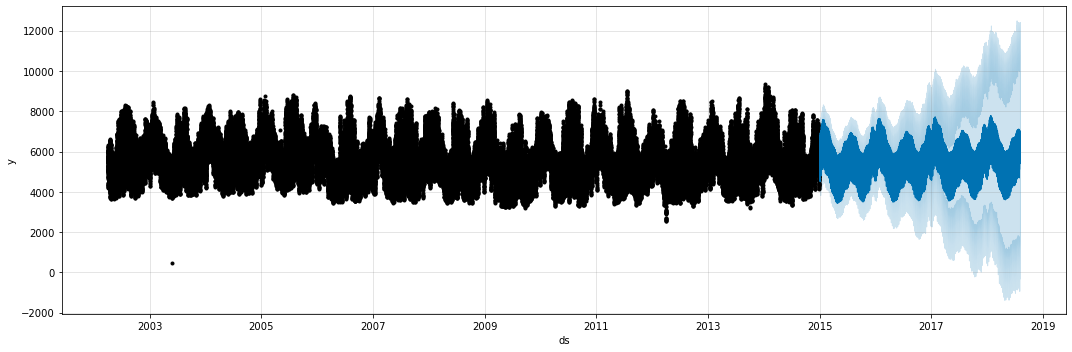

In [45]:
# Plot the forecast
fig, ax = plt.subplots(figsize= (15,5))

fig = model.plot(test_fcst, ax=ax)

plt.show()

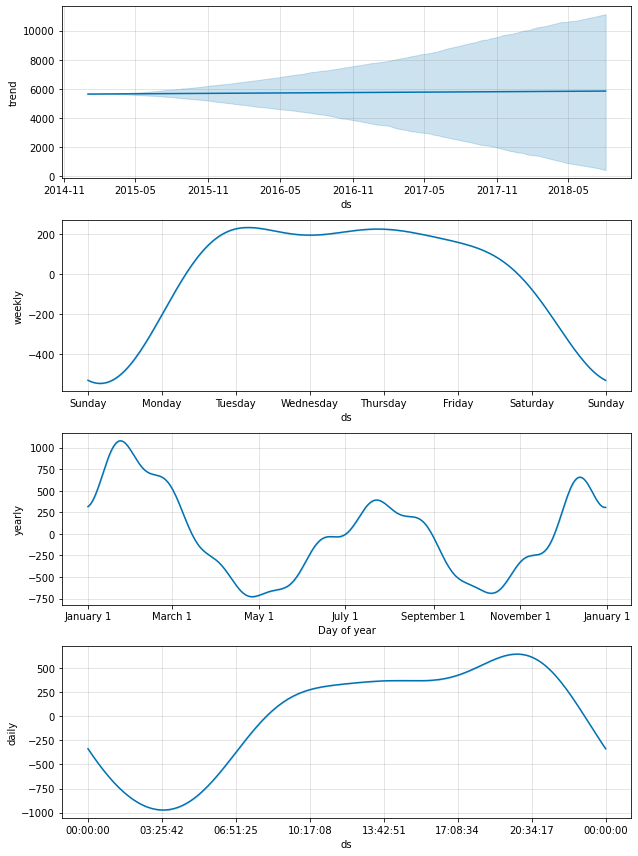

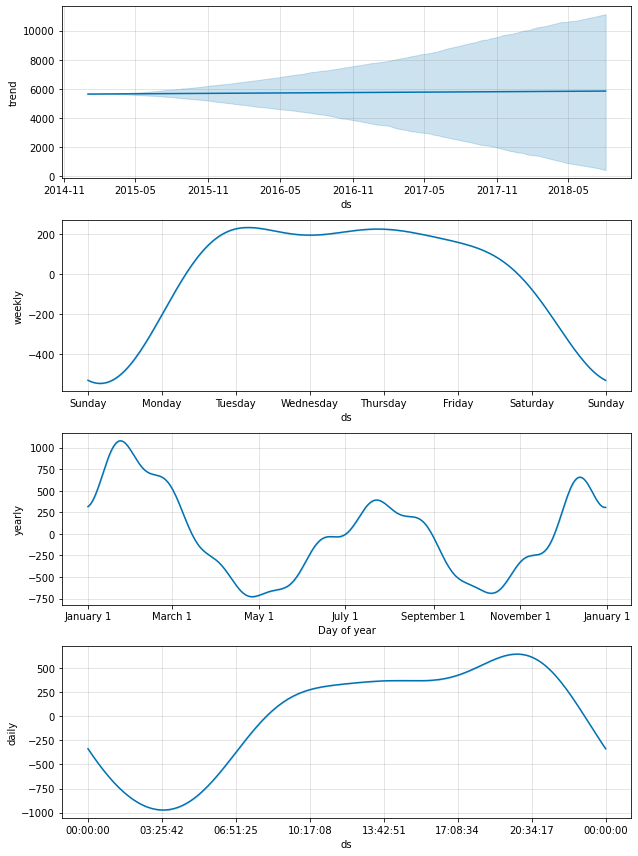

In [46]:
model.plot_components(test_fcst)